# Comparing 3D CNN, and Vision Transformer feature extractors for Isolated Sign Language Recognition

In [1]:
from test import set_seed
import json

In [2]:
set_seed()
imp_path = 'wlasl_implemented_info.json'
runs_path = 'runs'
classes_path = 'wlasl_class_list.json'
root_path = '../data/WLASL/WLASL2000'


In [ ]:
import test_claude

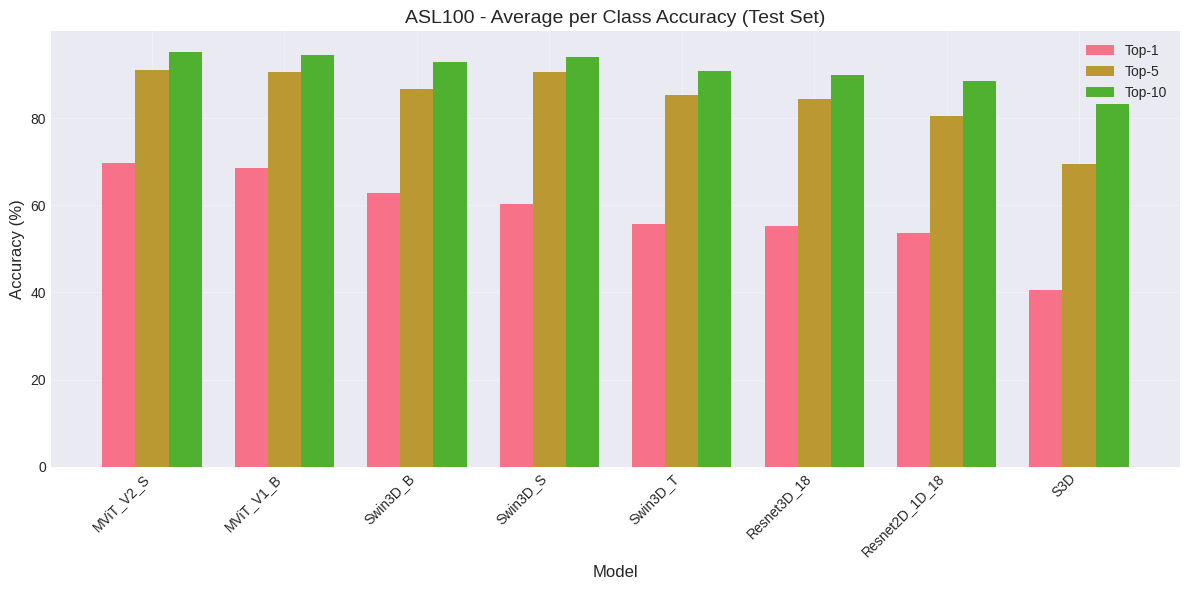

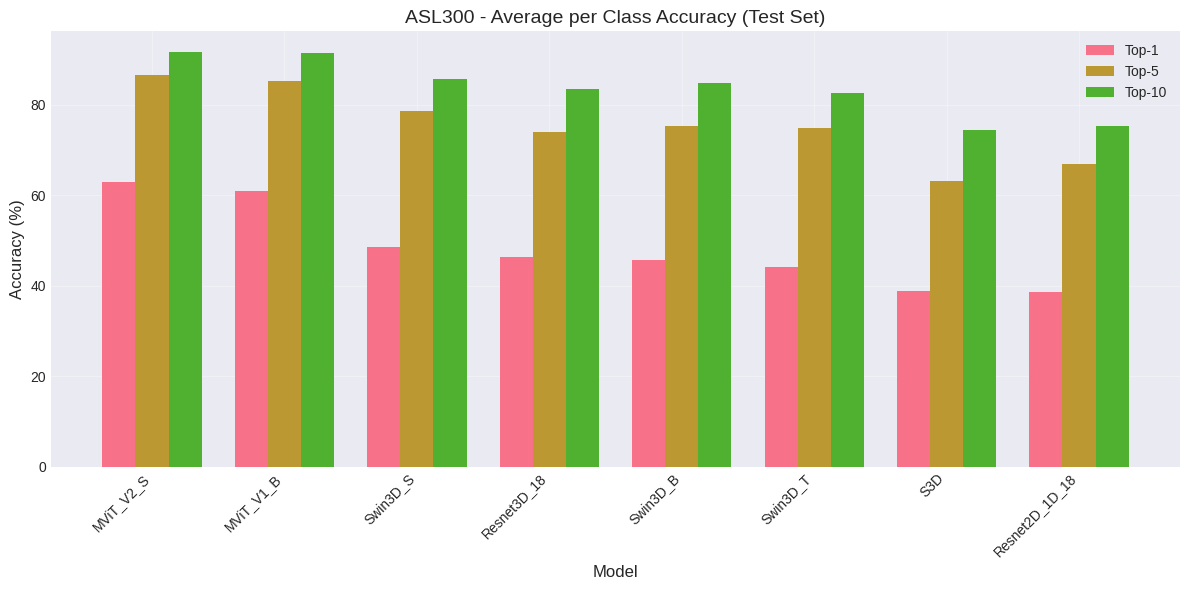

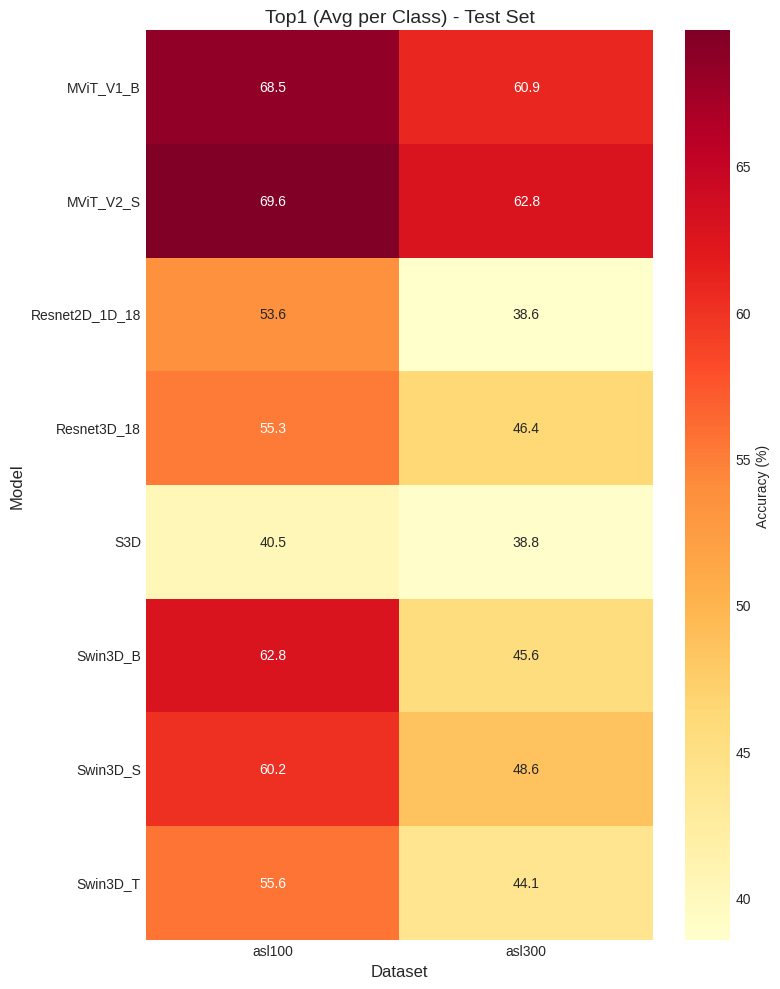

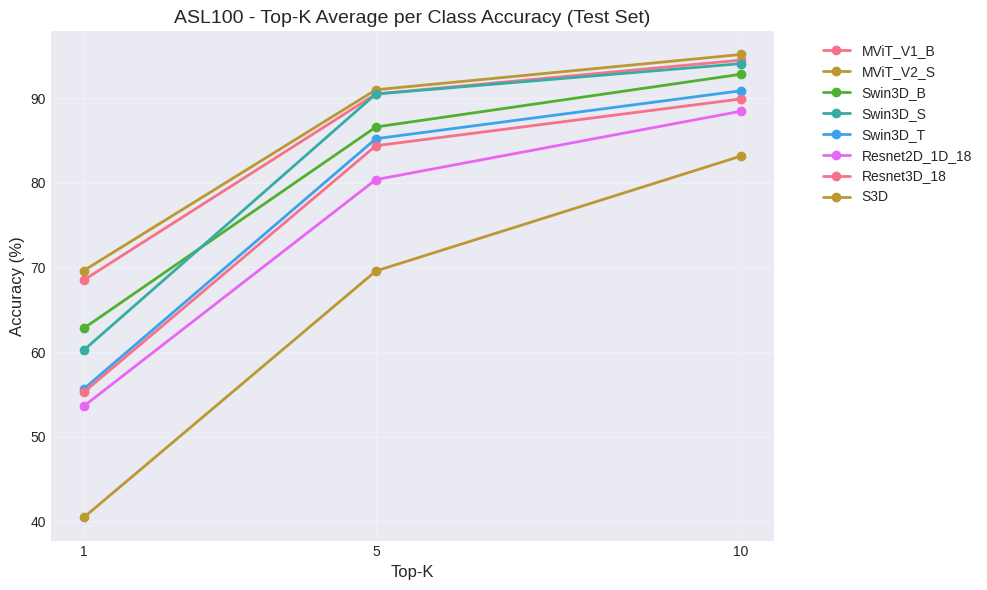

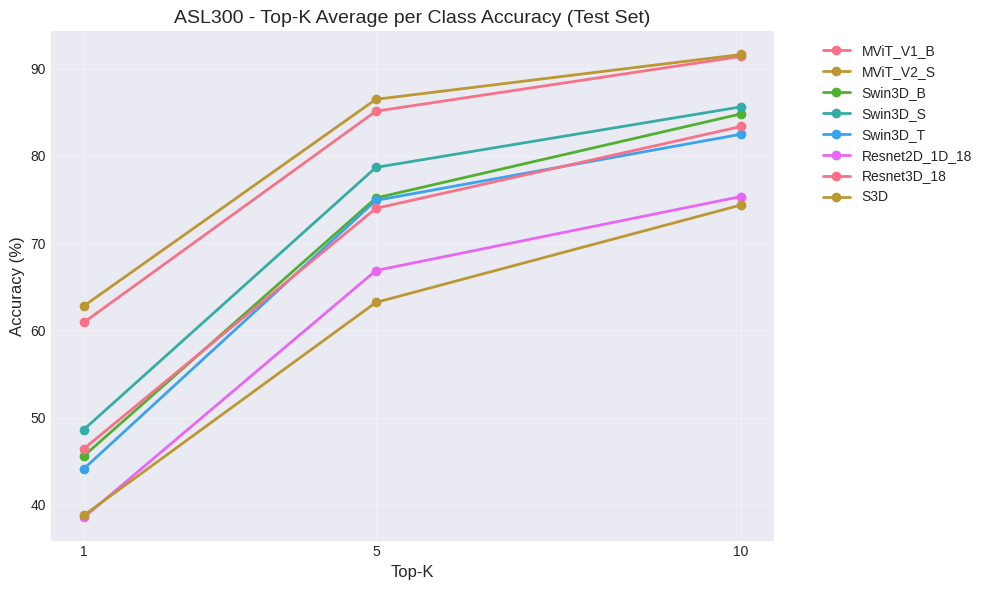

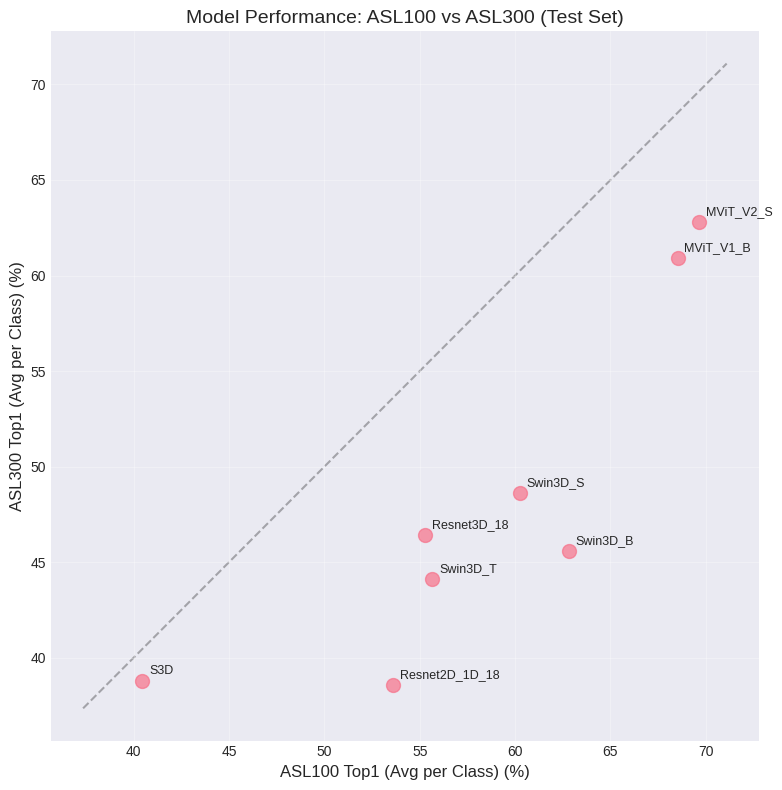

ASL100 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL100 Test Set Results (\% Accuracy)}
\label{tab:asl100_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
MViT\_V2\_S & 69.6 & 91.0 & 95.2 & 69.0 & 90.7 & 95.0 \\
MViT\_V1\_B & 68.5 & 90.5 & 94.5 & 67.8 & 89.9 & 94.2 \\
Swin3D\_B & 62.8 & 86.6 & 92.8 & 62.8 & 86.0 & 92.6 \\
Swin3D\_S & 60.2 & 90.5 & 94.1 & 59.7 & 90.3 & 94.2 \\
Swin3D\_T & 55.6 & 85.2 & 90.9 & 55.0 & 85.3 & 90.7 \\
Resnet3D\_18 & 55.3 & 84.4 & 89.9 & 55.4 & 84.1 & 89.9 \\
Resnet2D\_1D\_18 & 53.6 & 80.4 & 88.5 & 52.7 & 79.5 & 87.6 \\
S3D & 40.5 & 69.6 & 83.2 & 41.1 & 69.8 & 82.9 \\
\bottomrule
\end{tabular}
\end{table}


ASL300 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL300 Test Set Results (\% Accuracy)}
\label{tab:asl300_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
MViT\_V2\_S 

In [ ]:
df, results = test_claude.run_visualizations('wlasl_runs_summary.json')

In [ ]:
# latex_table = test_claude.generate_latex_table(
#     results, 
#     dataset='asl100', 
#     split='test',
#     metric_type='avg',  # or 'inst' or 'both'
#     caption='Your Caption',
#     label='tab:your_label'
# )
# print(latex_table)

### TODO: a plot of compute/size vs accuracy would be great if we have time

In [7]:
def sum_conv(n_dict):
  #essentially convert it back to the old format 
  new_dict = {}
  for split in n_dict.keys():
    new_dict[split] = {}
    for arch in n_dict[split].keys():
      new_dict[split][arch] = {}
      new_dict[split][arch]['best_test'] = n_dict[split][arch]['test set']
  return new_dict


# with open('wlasl_flipped_summary.json', 'r') as f:
#   res = json.load(f)
  
# converted = sum_conv(res)
# print(json.dumps(converted, indent=2))


# Flipped frame results

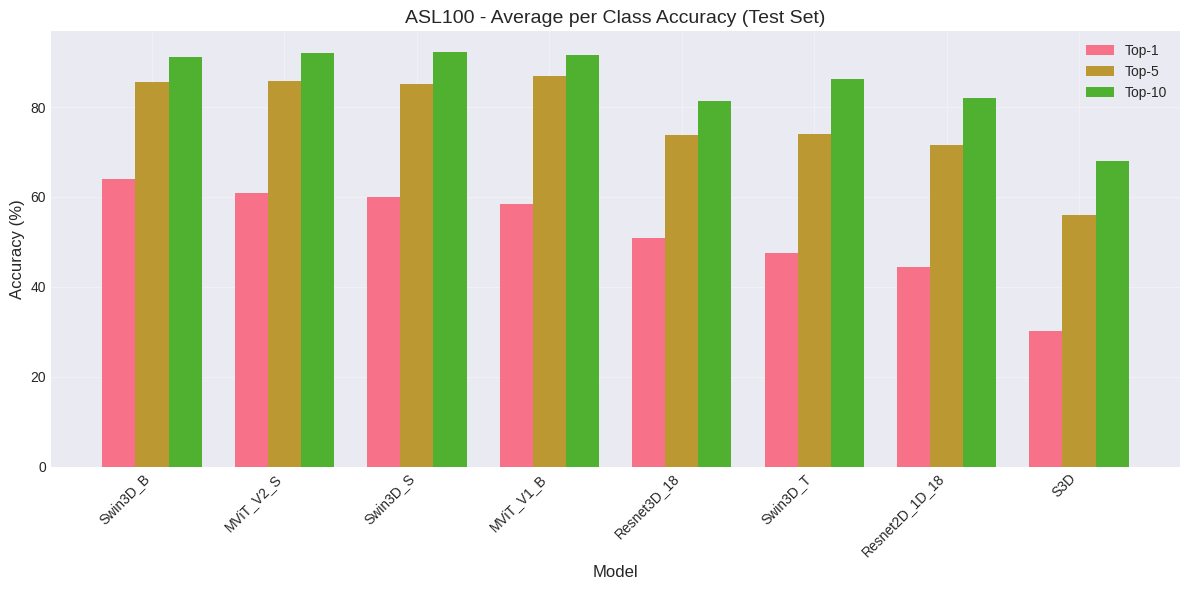

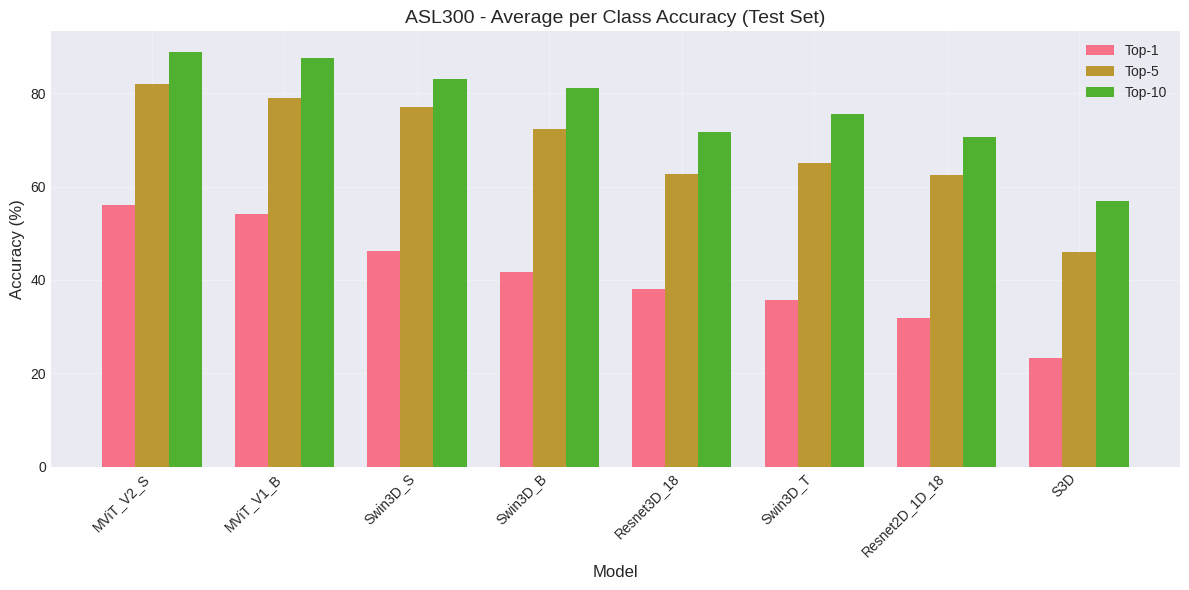

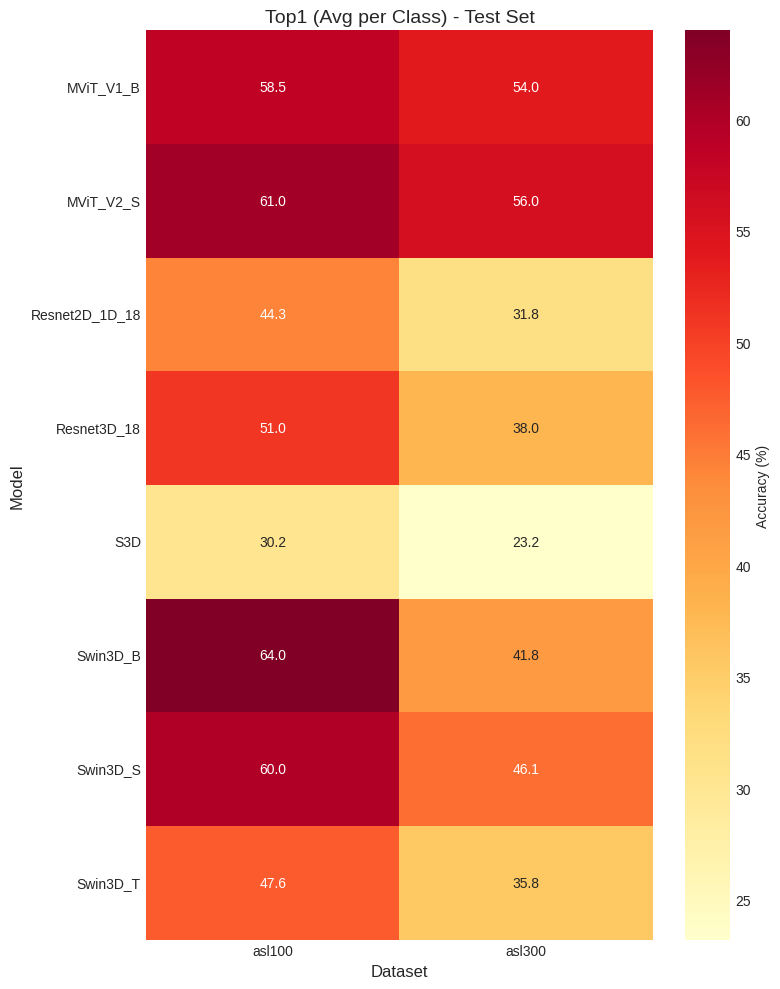

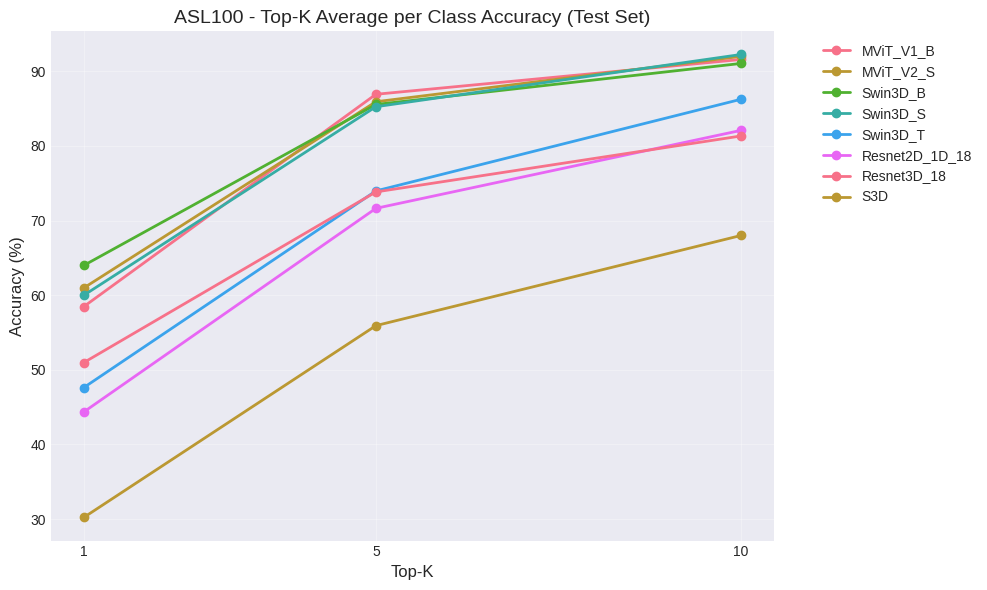

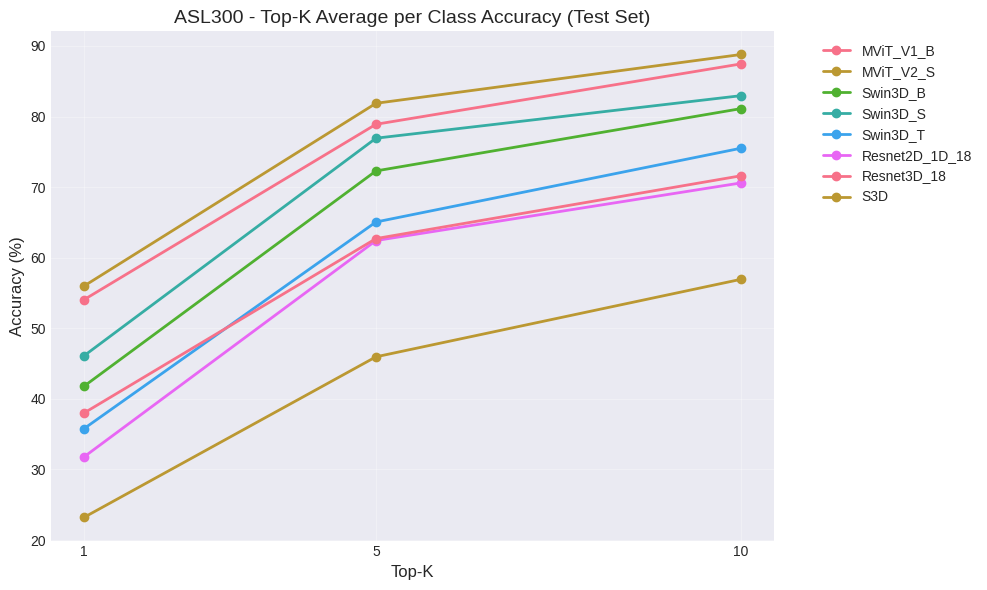

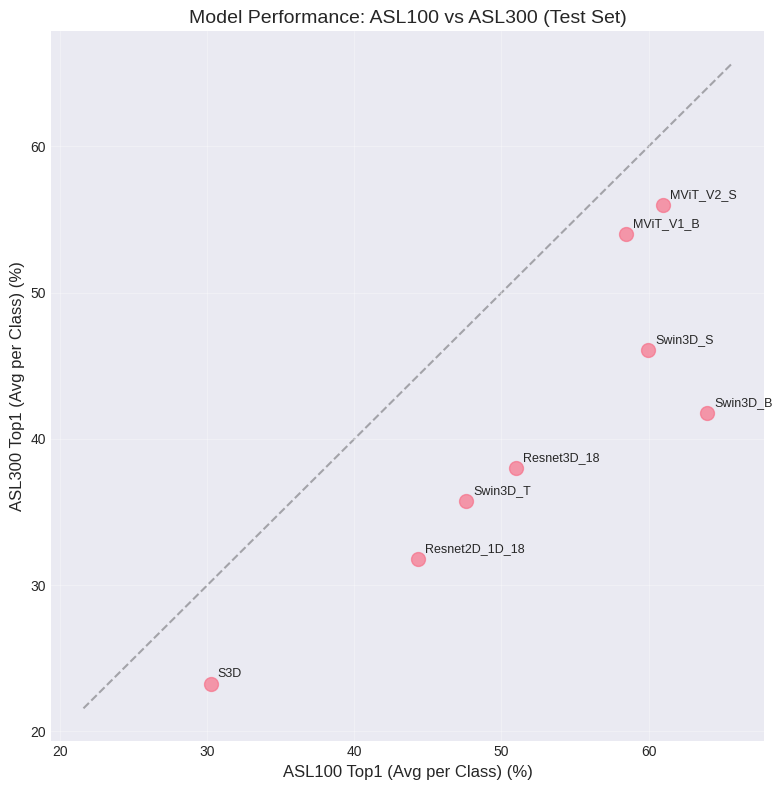

ASL100 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL100 Test Set Results (\% Accuracy)}
\label{tab:asl100_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
Swin3D\_B & 64.0 & 85.5 & 91.1 & 63.2 & 84.9 & 90.7 \\
MViT\_V2\_S & 61.0 & 85.9 & 92.0 & 60.5 & 86.0 & 92.2 \\
Swin3D\_S & 60.0 & 85.2 & 92.2 & 59.3 & 84.9 & 92.2 \\
MViT\_V1\_B & 58.5 & 86.9 & 91.6 & 58.5 & 87.2 & 91.9 \\
Resnet3D\_18 & 51.0 & 73.8 & 81.3 & 50.8 & 74.8 & 81.8 \\
Swin3D\_T & 47.6 & 74.0 & 86.2 & 47.3 & 74.0 & 86.0 \\
Resnet2D\_1D\_18 & 44.3 & 71.6 & 82.1 & 44.2 & 72.1 & 82.2 \\
S3D & 30.2 & 55.9 & 68.0 & 30.6 & 56.6 & 69.0 \\
\bottomrule
\end{tabular}
\end{table}


ASL300 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL300 Test Set Results (\% Accuracy)}
\label{tab:asl300_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
MViT\_V2\_S 

In [8]:
df_flip, res_flip = test_claude.run_visualizations('wlasl_flipped_summary.json', sum_conv)

## comparison

In [ ]:
import test_claude2

normal_file = 'wlasl_runs_summary.json'
flipped_file = 'wlasl_flipped_summary.json'

# Run complete comparison
combined_df, summary = test_claude2.run_temporal_comparison(normal_file, flipped_file)